# Load image

In [1]:

import matplotlib.pyplot as plt
import cv2 
import numpy as np

%matplotlib inline

image_path = "./image/three_ships_horizon.JPG"
# image_path = "./image/ship_new_test.jpg"
image = cv2.imread(image_path)
H, W, D = image.shape
print(H, W, D)


1200 1600 3


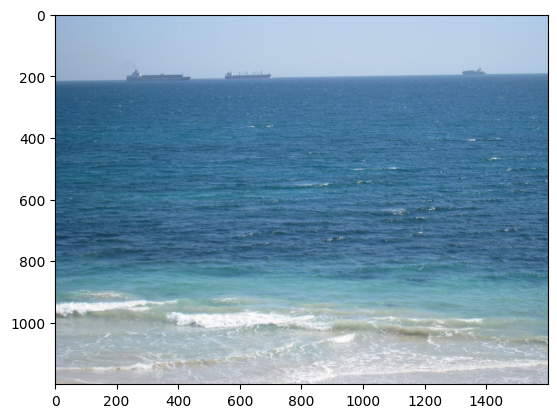

In [2]:
def cv2_imshow(cv2image):
    plt.imshow(cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB))
    plt.show()

cv2_imshow(image)


# Horizon line detection

## Segment by color

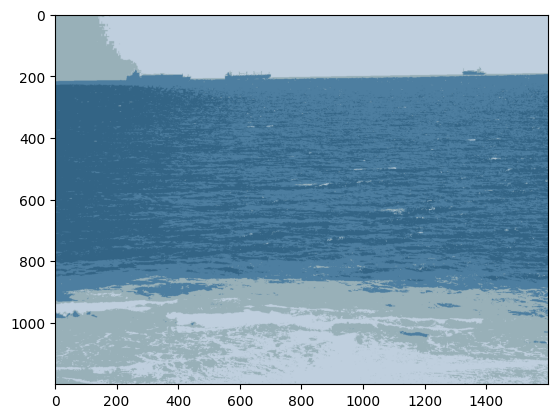

In [13]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixel_values = image_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define criteria and apply k-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4  # Number of clusters
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(image_rgb.shape)

result_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
cv2_imshow(result_image)


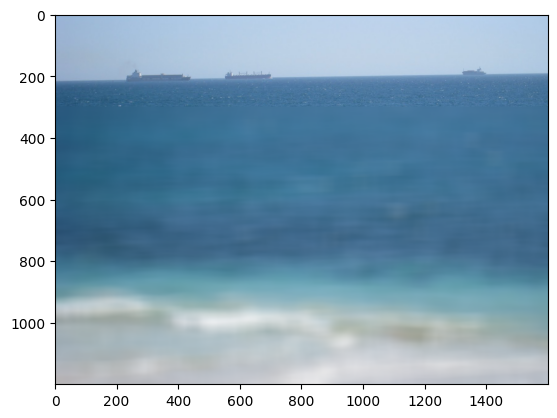

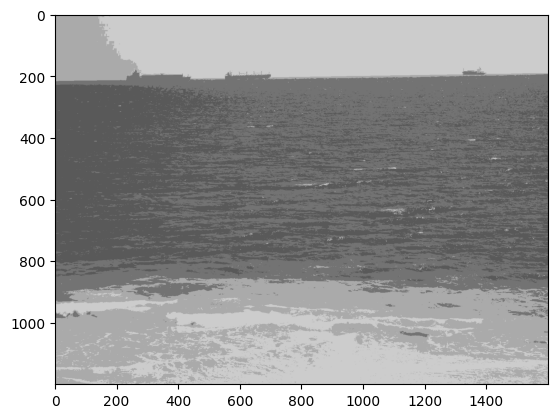

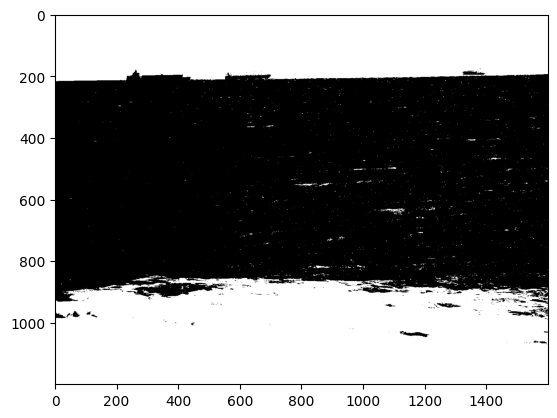

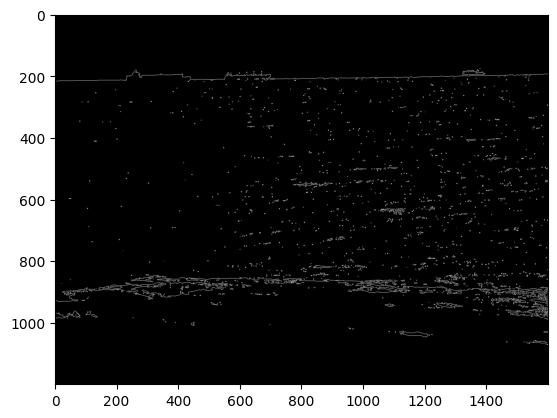

In [14]:
blur_img = image.copy()
blur_img[H//4:H, :] = cv2.blur(blur_img[H//4:H,:],(50,50))
# blur_img[H//6*4:H, :] = cv2.blur(blur_img[H//6*4:H,:],(50,50))
# blur_img[:H//5*3, :] = cv2.blur(blur_img[:H//5*3,:],(50,50))
gray = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
cv2_imshow(blur_img)
cv2_imshow(gray)
cv2_imshow(thresh)
cv2_imshow(edges)

## HoughLines Polar

[[[223.          1.553343 ]]

 [[848.          1.5882496]]

 [[844.          1.6057029]]

 [[863.          1.5707964]]

 [[821.          1.6231562]]

 [[898.          1.5358897]]

 [[894.          1.5358897]]

 [[900.          1.5358897]]

 [[896.          1.5358897]]

 [[865.          1.5707964]]

 [[881.          1.553343 ]]

 [[851.          1.5882496]]

 [[872.          1.5707964]]]


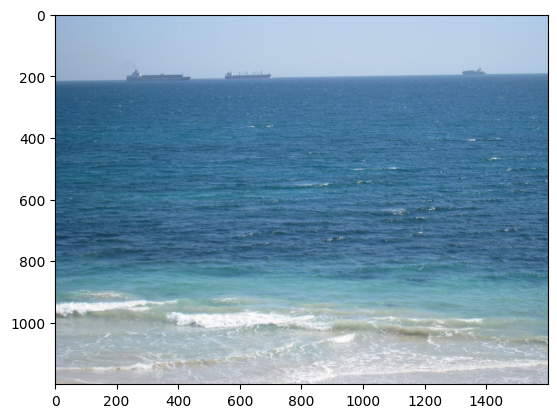

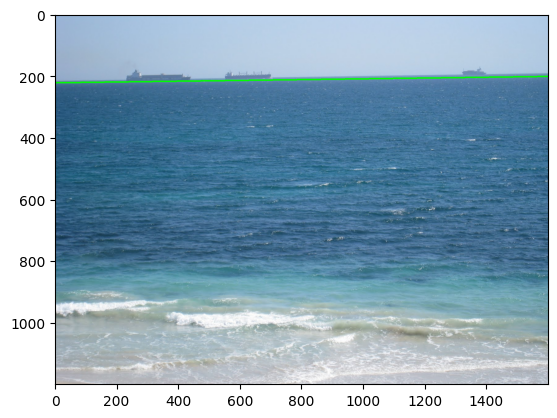

In [15]:

lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

print(lines)

line_draw_img = image.copy()
line = lines[0]
rho, theta = line[0][0], line[0][1]

cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
x0 = cos_theta * rho
y0 = sin_theta * rho
x1 = int(x0 + W * (-sin_theta))
y1 = int(y0 + H * (cos_theta))
x2 = int(x0 - W * (-sin_theta))
y2 = int(y0 - H * (cos_theta))
    
cv2.line(line_draw_img, (x1, y1), (x2,y2), (0, 255, 0), 3)    

cv2_imshow(image)
cv2_imshow(line_draw_img)

In [6]:
x0, y0, x1, y1, x2, y2, cos_theta, sin_theta, theta

(-9.572794e-06, 219.0, -1600, 218, 1599, 219, -4.371139e-08, 1.0, 1.5707964)

# Leveling horizon line

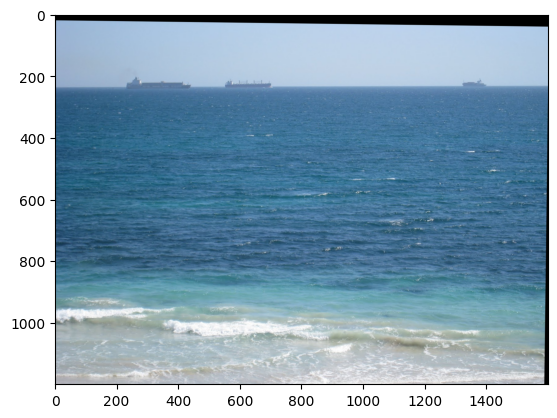

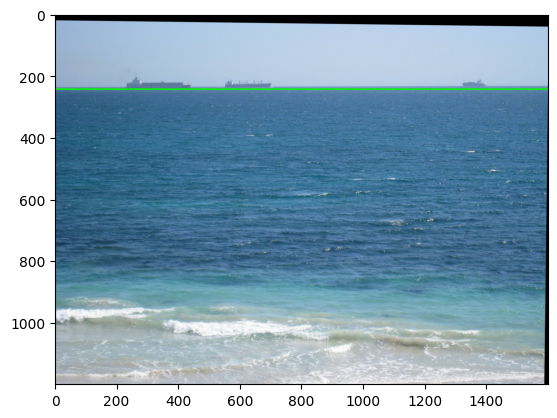

In [16]:
level_angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

rotate_matrix = cv2.getRotationMatrix2D((x1,y1), angle=level_angle, scale=1) 
rotated_image = cv2.warpAffine( 
    src=image, M=rotate_matrix, dsize=(image.shape[1], image.shape[0])) 
rotated_image_with_line = cv2.warpAffine( 
    src=line_draw_img, M=rotate_matrix, dsize=(image.shape[1], image.shape[0])) 
cv2_imshow(rotated_image)
cv2_imshow(rotated_image_with_line)


# Crop black boundary

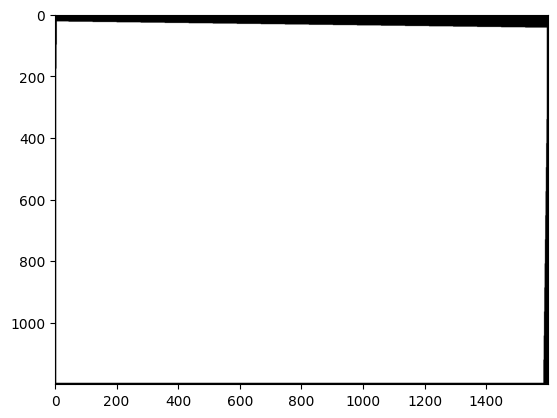

In [17]:
grayscale = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
ret, thresholded = cv2.threshold(grayscale, 0, 255, 0)

bbox = cv2.boundingRect(thresholded)
x, y, w, h = bbox
contours, hier= cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


for k, _ in enumerate(contours):
    im = cv2.cvtColor(cv2.drawContours(thresholded, contours, k, (0, 0, 255), 6),cv2.COLOR_BGR2RGB)

plt.imshow(im)


In [18]:
x, y = contours[0].T[0][0], contours[0].T[1][0]
x, y

(array([   3,    2,    2,    1,    1,    0,    0, 1587, 1588, 1588, 1589,
        1589, 1590, 1590, 1591, 1591, 1592, 1592, 1593, 1593, 1594, 1594,
        1595, 1595, 1596, 1596, 1597, 1597, 1598, 1598, 1599, 1599, 1526,
        1525, 1448, 1447, 1370, 1369, 1292, 1291, 1214, 1213, 1136, 1135,
        1058, 1057,  980,  979,  902,  901,  824,  823,  746,  745,  668,
         667,  590,  589,  512,  511,  434,  433,  356,  355,  278,  277,
         200,  199,  122,  121,   44,   43], dtype=int32),
 array([  20,   21,   98,   99,  176,  177, 1199, 1199, 1198, 1121, 1120,
        1043, 1042,  965,  964,  887,  886,  809,  808,  731,  730,  653,
         652,  575,  574,  497,  496,  419,  418,  341,  340,   40,   40,
          39,   39,   38,   38,   37,   37,   36,   36,   35,   35,   34,
          34,   33,   33,   32,   32,   31,   31,   30,   30,   29,   29,
          28,   28,   27,   27,   26,   26,   25,   25,   24,   24,   23,
          23,   22,   22,   21,   21,   20], dtype=in

In [19]:
def find_contours_boundary(x,y, mode = np.argmax): 
    x_arg = len(x)-mode(x[::-1])-1
    return y[x_arg]


In [20]:
y_at_x_max = find_contours_boundary(x, y)
x_at_y_max = find_contours_boundary(y, x)
x_min = find_contours_boundary(y, x, np.argmin)
cropped_image = rotated_image[y_at_x_max+2:y_at_x_max+h-2,x_min :x_at_y_max]
cropped_image_with_line = rotated_image_with_line[y_at_x_max+2:y_at_x_max+h-2,x_min:x_at_y_max]

43 1587


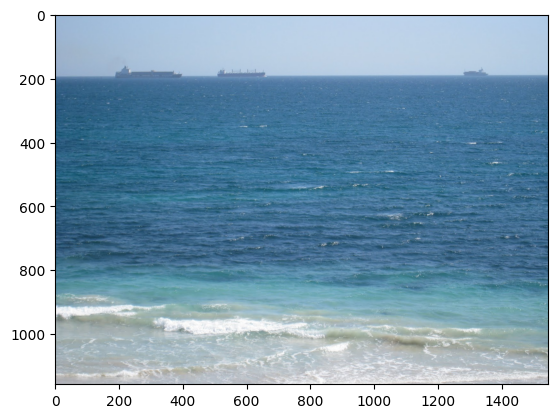

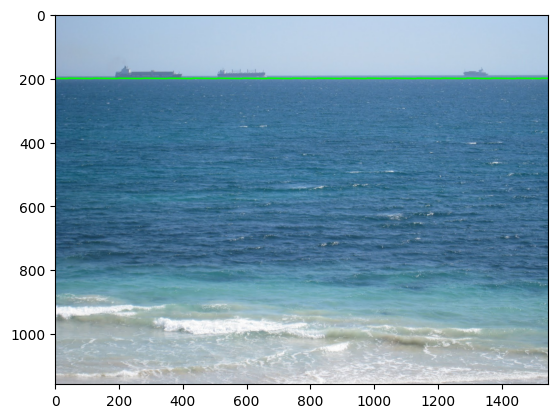

In [21]:
print(x_min, x_at_y_max)
cv2_imshow(cropped_image)
cv2_imshow(cropped_image_with_line)

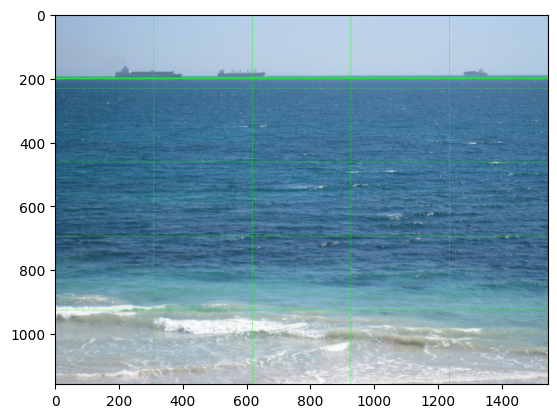

In [22]:
import cv2 as cv  
import numpy as np

# view grid to check level
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

draw_grid(cropped_image_with_line, (5,5))
cv2_imshow(cropped_image_with_line)

# Ship detection

In [23]:
# redetect line
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_TOZERO)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

print(lines)

# detect objects from this line
line = lines[0]
rho, theta = line[0][0], line[0][1]

cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
x0 = cos_theta * rho
y0 = sin_theta * rho
x1 = int(x0 + cropped_image.shape[1] * (-sin_theta))
y1 = int(y0 + cropped_image.shape[0] * (cos_theta))
x2 = int(x0 - cropped_image.shape[1] * (-sin_theta))
y2 = int(y0 - cropped_image.shape[0] * (cos_theta))
print(y1)


[[[ 191.           1.5707964]]

 [[ 716.           1.5358897]]

 [[1125.           1.5882496]]

 [[1132.           1.5707964]]

 [[1126.           1.5707964]]

 [[1135.           1.5707964]]

 [[1053.           1.6231562]]

 [[ 491.           1.6231562]]

 [[1128.           1.5882496]]

 [[ 749.           1.4835298]]

 [[ 706.           1.553343 ]]

 [[1129.           1.5707964]]

 [[1170.           1.5358897]]

 [[ 555.           1.553343 ]]

 [[ 621.           1.553343 ]]

 [[1122.           1.5882496]]

 [[ 930.           1.7104226]]

 [[ 466.           1.5707964]]

 [[1114.           1.5882496]]

 [[1175.           1.5358897]]

 [[1151.           1.553343 ]]

 [[ 738.           1.5009831]]

 [[1155.           1.553343 ]]

 [[1138.           1.5707964]]

 [[ 646.           1.553343 ]]

 [[ 548.           1.5358897]]

 [[ 933.           1.7104226]]

 [[ 541.           1.5707964]]

 [[ 629.           1.5707964]]

 [[ 473.           1.5358897]]

 [[ 553.           1.553343 ]]

 [[1051.

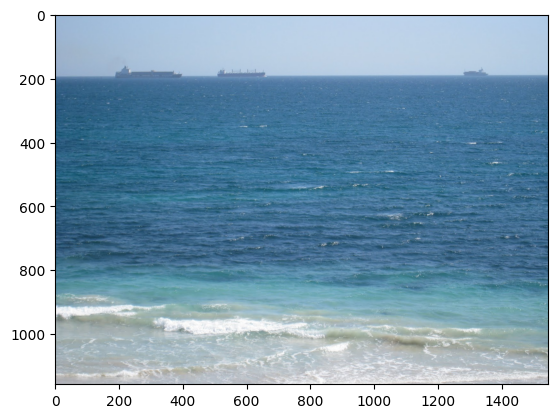

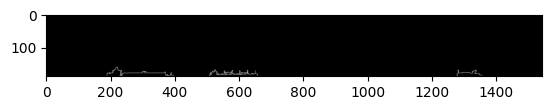

In [24]:
blur_img = cropped_image.copy()
cropped_image_upper= cropped_image[0: y1, :]
# cropped_image_upper = cropped_image[y1:, :]
gray = cv2.cvtColor(cropped_image_upper, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_TOZERO)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
kernel_size = (5,5)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2_imshow(cropped_image)
cv2_imshow(edges)

1278 171 80 19
508 170 151 20
189 162 209 28


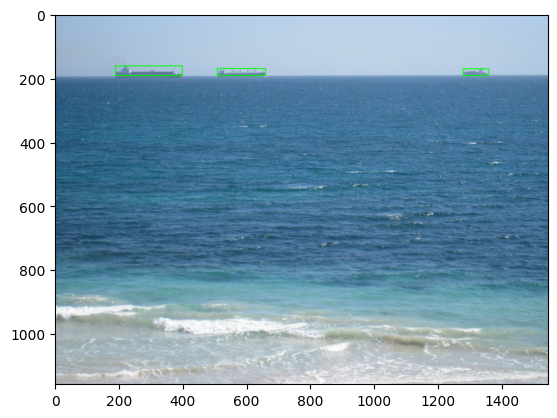

In [25]:
ship_detect = cropped_image.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    print(x, y, w, h)
    cv2.rectangle(ship_detect, (x, y), (x + w, y+ h+2), (0, 255, 0), 2)

cv2_imshow(ship_detect)